In [1]:
'''
Author: ChenHJ
Date: 2022-10-30 18:47:32
LastEditors: ChenHJ
LastEditTime: 2022-10-30 18:48:24
FilePath: /chenhj/0302code/obs_divide_SASMR.ipynb
Aim: 
11/18/2022:
计算了印度半岛南部降水和前冬Nino3.4 index的偏回归结果

11/13/2022:
计算了印度半岛北部和南部降水的偏相关

11/04/2022:
重新计算了不同季节的omega回归到降水

11/03/2022:
将印度半岛北部和南部的界限分别定在20和25度进行计算

11/02/2022:
使用CRU陆地降水数据再次计算印度半岛北部和南部降水的相关不同环流、海温过程等

10/30/2022: 
这个脚本用于计算在观测-再分析数据中, 印度半岛北部和南部降水的不同的相关环流, 海温过程等等（使用GPCP数据进行计算）
Mission: 
'''
from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof
import statsmodels.api as sm

## 计算印度半岛北部、南部降水相关的环流、海温等等

### 读取数据

In [3]:
fpreGPCP = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/GPCP_r144x72_197901-201412.nc"
)
preGPCP = fpreGPCP["precip"]
preGPCP_JJA = ca.p_time(preGPCP, 6, 8, True)
preGPCP_JJA = ca.detrend_dim(preGPCP_JJA, "time", deg=1, demean=False)

preAIR = xr.open_dataarray("/home/ys17-23/Extension/All_India_Rainfall_index/AIR_mmperday.nc")
preAIR_JJA = ca.p_time(preAIR, 6, 8, True)
preAIR_JJA = preAIR_JJA.sel(time=(preAIR_JJA.time.dt.year>=1979) & (preAIR_JJA.time.dt.year <=2014))
preAIR_JJA = ca.detrend_dim(preAIR_JJA, "time", deg=1, demean=False)

fpreCRU = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/cru_ts4.01_r144x72_195001-201412.nc")
preCRU = fpreCRU["pre"].sel(time=(fpreCRU["time"].dt.year>=1979) & (fpreCRU.time.dt.year<=2014))
preCRU_JJA = ca.p_time(preCRU, 6, 8, True)/30.67
preCRU_JJA.attrs["units"] = "mm/day"
preCRU_JJA = ca.detrend_dim(preCRU_JJA, "time", deg=1, demean=False)

fhgtERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/hgt_mon_r144x72_195001-201412.nc")
hgtERA5 = fhgtERA5["z"].sel(time=fhgtERA5["time"].dt.year>=1979)

fuERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/uwind_mon_r144x72_195001-201412.nc"
)
uERA5 = fuERA5["u"].sel(time=fuERA5["time"].dt.year>=1979)

fvERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/vwind_mon_r144x72_195001-201412.nc"
)
vERA5 = fvERA5["v"].sel(time=fvERA5["time"].dt.year>=1979)

fspERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/sp_mon_r144x72_195001-201412.nc"
)
spERA5 = fspERA5["sp"].sel(time=fspERA5["time"].dt.year>=1979)

fqERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/q_mon_r144x72_195001-201412.nc")
qERA5 = fqERA5["q"].sel(time=fqERA5["time"].dt.year>=1979)

fwERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/omega_mon_r144x72_195001-201412.nc")
wERA5 = fwERA5["w"].sel(time=fwERA5["time"].dt.year>=1979)

fsstHad = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/HadISST_r144x72_1870-2020.nc")
sstHad = fsstHad["sst"].sel(time=(fsstHad["time"].dt.year>=1979) & (fsstHad["time"].dt.year<=2014))

hgtERA5_ver_JJA = ca.p_time(hgtERA5, 6, 8, True)
hgtERA5_ver_JJA = hgtERA5_ver_JJA-hgtERA5_ver_JJA.mean(dim="lon", skipna=True)
hgtERA5_ver_JJA = ca.detrend_dim(hgtERA5_ver_JJA, "time", deg=1, demean=False)
uERA5_ver_JJA = ca.p_time(uERA5, 6, 8, True)
uERA5_ver_JJA = ca.detrend_dim(uERA5_ver_JJA, "time", deg=1, demean=False)
vERA5_ver_JJA = ca.p_time(vERA5, 6, 8, True)
vERA5_ver_JJA = ca.detrend_dim(vERA5_ver_JJA, "time", deg=1, demean=False)
qERA5_ver_JJA = ca.p_time(qERA5, 6, 9, True)
qERA5_ver_JJA = ca.detrend_dim(qERA5_ver_JJA, "time", deg=1, demean=False)
spERA5_JJA = ca.p_time(spERA5, 6, 8, True)
spERA5_JJA = ca.detrend_dim(spERA5_JJA, "time", deg=1, demean=False)
wERA5_MAM, wERA5_JJA, wERA5_SON, wERA5_DJF = ca.mon_to_season(wERA5)
wERA5_MAM = ca.detrend_dim(wERA5_MAM, "time", deg=1, demean=False)
wERA5_JJA = ca.detrend_dim(wERA5_JJA, "time", deg=1, demean=False)
wERA5_SON = ca.detrend_dim(wERA5_SON, "time", deg=1, demean=False)
wERA5_DJF = ca.detrend_dim(wERA5_DJF, "time", deg=1, demean=False)
sstHad_MAM, sstHad_JJA, sstHad_SON, sstHad_DJF = ca.mon_to_season(sstHad)
sstHad_MAM = ca.detrend_dim(sstHad_MAM, "time", deg=1, demean=False)
sstHad_JJA = ca.detrend_dim(sstHad_JJA, "time", deg=1, demean=False)
sstHad_SON = ca.detrend_dim(sstHad_SON, "time", deg=1, demean=False)
sstHad_DJF = ca.detrend_dim(sstHad_DJF, "time", deg=1, demean=False)
ftERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/temp_mon_r144x72_195001-201412.nc")
tERA5 = ftERA5["t"].sel(time=ftERA5["time"].dt.year>=1979)
tERA5_ver_JJA = ca.p_time(tERA5, 6, 8, True)
tERA5_ver_JJA = ca.detrend_dim(tERA5_ver_JJA, "time", deg=1, demean=False)
divERA5_ver_JJA = ca.cal_divergence(uERA5_ver_JJA.sel(level=[200.0, 850.0]), vERA5_ver_JJA.sel(level=[200.0, 850.0]))
divERA5_ver_JJA = ca.detrend_dim(divERA5_ver_JJA, "time", deg=1, demean=False)

#   calculate the waver vapor vertical intergration
ptop = 1
g = 9.8
ERA5level = qERA5_ver_JJA.coords["level"].where(qERA5_ver_JJA.coords["level"] >= ptop) * 100.0
ERA5level.attrs["units"] = "Pa"
ERA5dp = geocat.comp.dpres_plevel(ERA5level, spERA5_JJA, ptop*100)
ERA5dpg = ERA5dp / g
ERA5dpg.attrs["units"] = "kg/m2"
# calculate the water vapor transport
integration_top = 200
uq_sl_ERA5_JJA = uERA5_ver_JJA.loc[:, integration_top:, :, :] * qERA5_ver_JJA.loc[:, integration_top:, :, :].data * 1000.0
vq_sl_ERA5_JJA = vERA5_ver_JJA.loc[:, integration_top:, :, :] * qERA5_ver_JJA.loc[:, integration_top:, :, :].data * 1000.0
uq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
vq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
# calculate the whole levels water vapor transport
uqERA5_ver_JJA = (uq_sl_ERA5_JJA * ERA5dpg[:, list(ERA5level).index(integration_top*100):, :, :].data).sum(dim="level") / 1e05
vqERA5_ver_JJA = (vq_sl_ERA5_JJA * ERA5dpg[:, list(ERA5level).index(integration_top*100):, :, :].data).sum(dim="level") / 1e05
uqERA5_ver_JJA.attrs["units"] = "g m-1 s-1"
vqERA5_ver_JJA.attrs["units"] = "g m-1 s-1"
uqERA5_ver_JJA = ca.detrend_dim(uqERA5_ver_JJA, "time", deg=1, demean=False)
vqERA5_ver_JJA = ca.detrend_dim(vqERA5_ver_JJA, "time", deg=1, demean=False)
# calculate the water vapor transportation divergence
uqvqdivERA5_ver_JJA = ca.cal_divergence(uqERA5_ver_JJA, vqERA5_ver_JJA)
uqvqdivERA5_ver_JJA = ca.detrend_dim(uqvqdivERA5_ver_JJA, "time", deg=1, demean=False)

In [4]:
# 计算Nino 3.4 index并去趋势
Nino34Had = ca.cal_area_weighted_mean(ca.filplonlat(sstHad.copy()).loc[:, -5:5, -170:-120])
Nino34Had = ca.detrend_dim(Nino34Had, "time", deg=1, demean=False)
Nino34Had_MAM, Nino34Had_JJA, Nino34Had_SON, Nino34Had_DJF = ca.mon_to_season(Nino34Had)
Nino34Had_MAM = ca.detrend_dim(Nino34Had_MAM, "time", deg=1, demean=False)
Nino34Had_JJA = ca.detrend_dim(Nino34Had_JJA, "time", deg=1, demean=False)
Nino34Had_SON = ca.detrend_dim(Nino34Had_SON, "time", deg=1, demean=False)
Nino34Had_DJF = ca.detrend_dim(Nino34Had_DJF, "time", deg=1, demean=False)
Nino34Had_MAM_nor = ca.standardize(Nino34Had_MAM)
Nino34Had_JJA_nor = ca.standardize(Nino34Had_JJA)
Nino34Had_SON_nor = ca.standardize(Nino34Had_SON)
Nino34Had_DJF_nor = ca.standardize(Nino34Had_DJF)

{'standard_name': 'sea_surface_temperature', 'long_name': 'sst', 'units': 'C', 'cell_methods': 'time: lat: lon: mean'}


Before flip, lon range is [0.0, 357.5].


After flip, lon range is [-180.0, 177.5].
{'standard_name': 'sea_surface_temperature', 'long_name': 'sst', 'units': 'C', 'cell_methods': 'time: lat: lon: mean'}


### 对降水进行分区

In [5]:
lat = preGPCP_JJA.coords["lat"]
lon = preGPCP_JJA.coords["lon"]
# 北部
nIndia_N = 35.0
nIndia_S = 20.0
nIndia_W = 70.0
nIndia_E = 85.0
lat_nIndia_range = lat[(lat >= nIndia_S) & (lat <= nIndia_N)]
lon_nIndia_range = lon[(lon >= nIndia_W) & (lon <= nIndia_E)]

preGPCP_nIndia_JJA = ca.cal_lat_weighted_mean(preGPCP_JJA.sel(lat=lat_nIndia_range, lon=lon_nIndia_range)).mean(dim="lon", skipna=True)
preCRU_nIndia_JJA = ca.cal_area_weighted_mean(preCRU_JJA.sel(lat=lat_nIndia_range, lon=lon_nIndia_range))

preGPCP_nIndia_JJA = ca.detrend_dim(preGPCP_nIndia_JJA, "time", deg=1, demean=True)
preCRU_nIndia_JJA = ca.detrend_dim(preCRU_nIndia_JJA, "time", deg=1, demean=True)

# standardize
preGPCP_nIndia_JJA_nor = ca.standardize(preGPCP_nIndia_JJA)
preCRU_nIndia_JJA_nor = ca.standardize(preCRU_nIndia_JJA)

# 南部
sIndia_N = 20.0
sIndia_S = 5.0
sIndia_W = 70.0
sIndia_E = 85.0
lat_sIndia_range = lat[(lat >= sIndia_S) & (lat <= sIndia_N)]
lon_sIndia_range = lon[(lon >= sIndia_W) & (lon <= sIndia_E)]

preGPCP_sIndia_JJA = ca.cal_lat_weighted_mean(preGPCP_JJA.sel(lat=lat_sIndia_range, lon=lon_sIndia_range)).mean(dim="lon", skipna=True)
preCRU_sIndia_JJA = ca.cal_area_weighted_mean(preCRU_JJA.sel(lat=lat_sIndia_range, lon=lon_sIndia_range))

preGPCP_sIndia_JJA = ca.detrend_dim(preGPCP_sIndia_JJA, "time", deg=1, demean=True)
preCRU_sIndia_JJA = ca.detrend_dim(preCRU_sIndia_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_sIndia_JJA_nor = ca.standardize(preGPCP_sIndia_JJA)
preCRU_sIndia_JJA_nor = ca.standardize(preCRU_sIndia_JJA)

# 全印度
India_N = 35.0
India_S = 5.0
India_W = 70.0
India_E = 85.0
lat_India_range = lat[(lat >= India_S) & (lat <= India_N)]
lon_India_range = lon[(lon >= India_W) & (lon <= India_E)]

preGPCP_India_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_India_range, lon=lon_India_range))
preCRU_India_JJA = ca.cal_area_weighted_mean(preCRU_JJA.sel(lat=lat_India_range, lon=lon_India_range))

preGPCP_India_JJA = ca.detrend_dim(preGPCP_India_JJA, "time", deg=1, demean=True)
preCRU_India_JJA = ca.detrend_dim(preCRU_India_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_India_JJA_nor = ca.standardize(preGPCP_India_JJA)
preCRU_India_JJA_nor = ca.standardize(preCRU_India_JJA)

## GPCP

### 计算降水场回归、环流场回归

In [4]:
# 降水场
(
    nIndR_GPCP_pre_slope,
    nIndR_GPCP_pre_intercept,
    nIndR_GPCP_pre_rvalue,
    nIndR_GPCP_pre_pvalue,
    nIndR_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, preGPCP_JJA)

(
    sIndR_GPCP_pre_slope,
    sIndR_GPCP_pre_intercept,
    sIndR_GPCP_pre_rvalue,
    sIndR_GPCP_pre_pvalue,
    sIndR_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, preGPCP_JJA)

(
    IndR_GPCP_pre_slope,
    IndR_GPCP_pre_intercept,
    IndR_GPCP_pre_rvalue,
    IndR_GPCP_pre_pvalue,
    IndR_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, preGPCP_JJA)

In [5]:
# 环流场/风场
preGPCP_nIndia_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
preGPCP_sIndia_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
(
    nIndR_ERA5_hgt_slope,
    nIndR_ERA5_hgt_intercept,
    nIndR_ERA5_hgt_rvalue,
    nIndR_ERA5_hgt_pvalue,
    nIndR_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ERA5_u_slope,
    nIndR_ERA5_u_intercept,
    nIndR_ERA5_u_rvalue,
    nIndR_ERA5_u_pvalue,
    nIndR_ERA5_u_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ERA5_v_slope,
    nIndR_ERA5_v_intercept,
    nIndR_ERA5_v_rvalue,
    nIndR_ERA5_v_pvalue,
    nIndR_ERA5_v_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sIndR_ERA5_hgt_slope,
    sIndR_ERA5_hgt_intercept,
    sIndR_ERA5_hgt_rvalue,
    sIndR_ERA5_hgt_pvalue,
    sIndR_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sIndR_ERA5_u_slope,
    sIndR_ERA5_u_intercept,
    sIndR_ERA5_u_rvalue,
    sIndR_ERA5_u_pvalue,
    sIndR_ERA5_u_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sIndR_ERA5_v_slope,
    sIndR_ERA5_v_intercept,
    sIndR_ERA5_v_rvalue,
    sIndR_ERA5_v_pvalue,
    sIndR_ERA5_v_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    IndR_ERA5_hgt_slope,
    IndR_ERA5_hgt_intercept,
    IndR_ERA5_hgt_rvalue,
    IndR_ERA5_hgt_pvalue,
    IndR_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    IndR_ERA5_u_slope,
    IndR_ERA5_u_intercept,
    IndR_ERA5_u_rvalue,
    IndR_ERA5_u_pvalue,
    IndR_ERA5_u_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    IndR_ERA5_v_slope,
    IndR_ERA5_v_intercept,
    IndR_ERA5_v_rvalue,
    IndR_ERA5_v_pvalue,
    IndR_ERA5_v_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

In [6]:
# 垂直运动场和散度场
tmp = preGPCP_nIndia_JJA_nor[1:].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    nIndR_ERA5_wDJF_slope,
    nIndR_ERA5_wDJF_intercept,
    nIndR_ERA5_wDJF_rvalue,
    nIndR_ERA5_wDJF_pvalue,
    nIndR_ERA5_wDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

tmp = preGPCP_nIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_MAM.time
(
    nIndR_ERA5_wMAM_slope,
    nIndR_ERA5_wMAM_intercept,
    nIndR_ERA5_wMAM_rvalue,
    nIndR_ERA5_wMAM_pvalue,
    nIndR_ERA5_wMAM_hypothesis,
) = ca.dim_linregress(tmp, wERA5_MAM.sel(level=500.0))

tmp = preGPCP_nIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_JJA.time
(
    nIndR_ERA5_wJJA_slope,
    nIndR_ERA5_wJJA_intercept,
    nIndR_ERA5_wJJA_rvalue,
    nIndR_ERA5_wJJA_pvalue,
    nIndR_ERA5_wJJA_hypothesis,
) = ca.dim_linregress(tmp, wERA5_JJA.sel(level=500.0))

tmp = preGPCP_nIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_SON.time
(
    nIndR_ERA5_wSON_slope,
    nIndR_ERA5_wSON_intercept,
    nIndR_ERA5_wSON_rvalue,
    nIndR_ERA5_wSON_pvalue,
    nIndR_ERA5_wSON_hypothesis,
) = ca.dim_linregress(tmp, wERA5_SON.sel(level=500.0))

tmp = preGPCP_nIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    nIndR_ERA5_wnDJF_slope,
    nIndR_ERA5_wnDJF_intercept,
    nIndR_ERA5_wnDJF_rvalue,
    nIndR_ERA5_wnDJF_pvalue,
    nIndR_ERA5_wnDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

(
    nIndR_ERA5_div_slope,
    nIndR_ERA5_div_intercept,
    nIndR_ERA5_div_rvalue,
    nIndR_ERA5_div_pvalue,
    nIndR_ERA5_div_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

tmp = preGPCP_sIndia_JJA_nor[1:].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    sIndR_ERA5_wDJF_slope,
    sIndR_ERA5_wDJF_intercept,
    sIndR_ERA5_wDJF_rvalue,
    sIndR_ERA5_wDJF_pvalue,
    sIndR_ERA5_wDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

tmp = preGPCP_sIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_MAM.time
(
    sIndR_ERA5_wMAM_slope,
    sIndR_ERA5_wMAM_intercept,
    sIndR_ERA5_wMAM_rvalue,
    sIndR_ERA5_wMAM_pvalue,
    sIndR_ERA5_wMAM_hypothesis,
) = ca.dim_linregress(tmp, wERA5_MAM.sel(level=500.0))

tmp = preGPCP_sIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_JJA.time
(
    sIndR_ERA5_wJJA_slope,
    sIndR_ERA5_wJJA_intercept,
    sIndR_ERA5_wJJA_rvalue,
    sIndR_ERA5_wJJA_pvalue,
    sIndR_ERA5_wJJA_hypothesis,
) = ca.dim_linregress(tmp, wERA5_JJA.sel(level=500.0))

tmp = preGPCP_sIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_SON.time
(
    sIndR_ERA5_wSON_slope,
    sIndR_ERA5_wSON_intercept,
    sIndR_ERA5_wSON_rvalue,
    sIndR_ERA5_wSON_pvalue,
    sIndR_ERA5_wSON_hypothesis,
) = ca.dim_linregress(tmp, wERA5_SON.sel(level=500.0))

tmp = preGPCP_sIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    sIndR_ERA5_wnDJF_slope,
    sIndR_ERA5_wnDJF_intercept,
    sIndR_ERA5_wnDJF_rvalue,
    sIndR_ERA5_wnDJF_pvalue,
    sIndR_ERA5_wnDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

(
    sIndR_ERA5_div_slope,
    sIndR_ERA5_div_intercept,
    sIndR_ERA5_div_rvalue,
    sIndR_ERA5_div_pvalue,
    sIndR_ERA5_div_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

tmp = preGPCP_India_JJA_nor[1:].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    IndR_ERA5_wDJF_slope,
    IndR_ERA5_wDJF_intercept,
    IndR_ERA5_wDJF_rvalue,
    IndR_ERA5_wDJF_pvalue,
    IndR_ERA5_wDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

tmp = preGPCP_India_JJA_nor.copy()
tmp.coords["time"] = wERA5_MAM.time
(
    IndR_ERA5_wMAM_slope,
    IndR_ERA5_wMAM_intercept,
    IndR_ERA5_wMAM_rvalue,
    IndR_ERA5_wMAM_pvalue,
    IndR_ERA5_wMAM_hypothesis,
) = ca.dim_linregress(tmp, wERA5_MAM.sel(level=500.0))

tmp = preGPCP_India_JJA_nor.copy()
tmp.coords["time"] = wERA5_JJA.time
(
    IndR_ERA5_wJJA_slope,
    IndR_ERA5_wJJA_intercept,
    IndR_ERA5_wJJA_rvalue,
    IndR_ERA5_wJJA_pvalue,
    IndR_ERA5_wJJA_hypothesis,
) = ca.dim_linregress(tmp, wERA5_JJA.sel(level=500.0))

tmp = preGPCP_India_JJA_nor.copy()
tmp.coords["time"] = wERA5_SON.time
(
    IndR_ERA5_wSON_slope,
    IndR_ERA5_wSON_intercept,
    IndR_ERA5_wSON_rvalue,
    IndR_ERA5_wSON_pvalue,
    IndR_ERA5_wSON_hypothesis,
) = ca.dim_linregress(tmp, wERA5_SON.sel(level=500.0))

tmp = preGPCP_India_JJA_nor[:-1].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    IndR_ERA5_wnDJF_slope,
    IndR_ERA5_wnDJF_intercept,
    IndR_ERA5_wnDJF_rvalue,
    IndR_ERA5_wnDJF_pvalue,
    IndR_ERA5_wnDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

(
    IndR_ERA5_div_slope,
    IndR_ERA5_div_intercept,
    IndR_ERA5_div_rvalue,
    IndR_ERA5_div_pvalue,
    IndR_ERA5_div_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

In [7]:
level = nIndR_ERA5_hgt_slope.coords["level"]

nIndR_GPCP_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_GPCP_pre_slope.data),
        intercept=(["lat", "lon"], nIndR_GPCP_pre_intercept.data),
        rvalue=(["lat", "lon"], nIndR_GPCP_pre_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_GPCP_pre_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_GPCP_pre_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="pre fields of GPCP regress onto 1979-2014 "),
)

nIndR_ERA5_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_hgt_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_hgt_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_hgt_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_u_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_u_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_u_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_u_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_u_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_v_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_v_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_v_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_v_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_v_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wMAM_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wMAM_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wMAM_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wMAM_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wJJA_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wJJA_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wJJA_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wJJA_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wSON_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wSON_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wSON_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wSON_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wnDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wnDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wnDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_div_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_div_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_div_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_div_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_div_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_div_hypothesis.data),
    ),
    coords=dict(
        level=nIndR_ERA5_div_slope.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
)

sIndR_GPCP_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_GPCP_pre_slope.data),
        intercept=(["lat", "lon"], sIndR_GPCP_pre_intercept.data),
        rvalue=(["lat", "lon"], sIndR_GPCP_pre_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_GPCP_pre_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_GPCP_pre_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="pre fields of GPCP regress onto 1979-2014 "),
)

sIndR_ERA5_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_hgt_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_hgt_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_hgt_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_hgt_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_hgt_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_u_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_u_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_u_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_u_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_u_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_v_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_v_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_v_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_v_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_v_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wMAM_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wMAM_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wMAM_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wMAM_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wJJA_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wJJA_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wJJA_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wJJA_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wSON_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wSON_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wSON_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wSON_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wnDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wnDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wnDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_div_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_div_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_div_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_div_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_div_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_div_hypothesis.data),
    ),
    coords=dict(
        level=sIndR_ERA5_div_slope.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
)

IndR_GPCP_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_GPCP_pre_slope.data),
        intercept=(["lat", "lon"], IndR_GPCP_pre_intercept.data),
        rvalue=(["lat", "lon"], IndR_GPCP_pre_rvalue.data),
        pvalue=(["lat", "lon"], IndR_GPCP_pre_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_GPCP_pre_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="pre fields of GPCP regress onto 1979-2014 "),
)

IndR_ERA5_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_hgt_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_hgt_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_hgt_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_hgt_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_hgt_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_u_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_u_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_u_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_u_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_u_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_v_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_v_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_v_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_v_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_v_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wMAM_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wMAM_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wMAM_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wMAM_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wJJA_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wJJA_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wJJA_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wJJA_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wSON_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wSON_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wSON_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wSON_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wnDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wnDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wnDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_div_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_div_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_div_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_div_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_div_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_div_hypothesis.data),
    ),
    coords=dict(
        level=IndR_ERA5_div_slope.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
)

if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_GPCP_pre_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_GPCP_pre_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_hgt_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_hgt_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_u_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_u_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_v_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_v_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wnDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_div_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_div_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_GPCP_pre_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_GPCP_pre_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_hgt_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_hgt_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_u_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_u_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_v_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_v_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wnDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_div_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_div_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_GPCP_pre_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_GPCP_pre_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_hgt_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_hgt_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_u_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_u_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_v_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_v_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wnDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_div_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_div_regress.nc")
# ====================================================================
nIndR_GPCP_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_GPCP_pre_regress.nc")
nIndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_hgt_regress.nc")
nIndR_ERA5_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_u_regress.nc")
nIndR_ERA5_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_v_regress.nc")
nIndR_ERA5_wDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wDJF_regress.nc")
nIndR_ERA5_wMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wMAM_regress.nc")
nIndR_ERA5_wJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wJJA_regress.nc")
nIndR_ERA5_wSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wSON_regress.nc")
nIndR_ERA5_wnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_wnDJF_regress.nc")
nIndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_div_regress.nc")

sIndR_GPCP_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_GPCP_pre_regress.nc")
sIndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_hgt_regress.nc")
sIndR_ERA5_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_u_regress.nc")
sIndR_ERA5_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_v_regress.nc")
sIndR_ERA5_wDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wDJF_regress.nc")
sIndR_ERA5_wMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wMAM_regress.nc")
sIndR_ERA5_wJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wJJA_regress.nc")
sIndR_ERA5_wSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wSON_regress.nc")
sIndR_ERA5_wnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_wnDJF_regress.nc")
sIndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_div_regress.nc")

IndR_GPCP_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_GPCP_pre_regress.nc")
IndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_hgt_regress.nc")
IndR_ERA5_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_u_regress.nc")
IndR_ERA5_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_v_regress.nc")
IndR_ERA5_wDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wDJF_regress.nc")
IndR_ERA5_wMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wMAM_regress.nc")
IndR_ERA5_wJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wJJA_regress.nc")
IndR_ERA5_wSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wSON_regress.nc")
IndR_ERA5_wnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_wnDJF_regress.nc")
IndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_div_regress.nc")

### 计算前期冬季、前期春期、同期夏季、后期秋季、后期冬季的海温回归异常

In [8]:
# 印度半岛北部降水
# 前期冬季
tmp = preGPCP_nIndia_JJA_nor[1:].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    nIndR_ERA5_sstDJF_slope,
    nIndR_ERA5_sstDJF_intercept,
    nIndR_ERA5_sstDJF_rvalue,
    nIndR_ERA5_sstDJF_pvalue,
    nIndR_ERA5_sstDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 前期春季
tmp = preGPCP_nIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_MAM.time
(
    nIndR_ERA5_sstMAM_slope,
    nIndR_ERA5_sstMAM_intercept,
    nIndR_ERA5_sstMAM_rvalue,
    nIndR_ERA5_sstMAM_pvalue,
    nIndR_ERA5_sstMAM_hypothesis,
) = ca.dim_linregress(tmp, sstHad_MAM)

# 同期夏季
tmp = preGPCP_nIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_JJA.time
(
    nIndR_ERA5_sstJJA_slope,
    nIndR_ERA5_sstJJA_intercept,
    nIndR_ERA5_sstJJA_rvalue,
    nIndR_ERA5_sstJJA_pvalue,
    nIndR_ERA5_sstJJA_hypothesis,
) = ca.dim_linregress(tmp, sstHad_JJA)

# 后期秋季
tmp = preGPCP_nIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_SON.time
(
    nIndR_ERA5_sstSON_slope,
    nIndR_ERA5_sstSON_intercept,
    nIndR_ERA5_sstSON_rvalue,
    nIndR_ERA5_sstSON_pvalue,
    nIndR_ERA5_sstSON_hypothesis,
) = ca.dim_linregress(tmp, sstHad_SON)

# 后期冬季
tmp = preGPCP_nIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    nIndR_ERA5_sstnDJF_slope,
    nIndR_ERA5_sstnDJF_intercept,
    nIndR_ERA5_sstnDJF_rvalue,
    nIndR_ERA5_sstnDJF_pvalue,
    nIndR_ERA5_sstnDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 印度半岛南部降水
# 前期冬季
tmp = preGPCP_sIndia_JJA_nor[1:].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    sIndR_ERA5_sstDJF_slope,
    sIndR_ERA5_sstDJF_intercept,
    sIndR_ERA5_sstDJF_rvalue,
    sIndR_ERA5_sstDJF_pvalue,
    sIndR_ERA5_sstDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 前期春季
tmp = preGPCP_sIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_MAM.time
(
    sIndR_ERA5_sstMAM_slope,
    sIndR_ERA5_sstMAM_intercept,
    sIndR_ERA5_sstMAM_rvalue,
    sIndR_ERA5_sstMAM_pvalue,
    sIndR_ERA5_sstMAM_hypothesis,
) = ca.dim_linregress(tmp, sstHad_MAM)

# 同期夏季
tmp = preGPCP_sIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_JJA.time
(
    sIndR_ERA5_sstJJA_slope,
    sIndR_ERA5_sstJJA_intercept,
    sIndR_ERA5_sstJJA_rvalue,
    sIndR_ERA5_sstJJA_pvalue,
    sIndR_ERA5_sstJJA_hypothesis,
) = ca.dim_linregress(tmp, sstHad_JJA)

# 后期秋季
tmp = preGPCP_sIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_SON.time
(
    sIndR_ERA5_sstSON_slope,
    sIndR_ERA5_sstSON_intercept,
    sIndR_ERA5_sstSON_rvalue,
    sIndR_ERA5_sstSON_pvalue,
    sIndR_ERA5_sstSON_hypothesis,
) = ca.dim_linregress(tmp, sstHad_SON)

# 后期冬季
tmp = preGPCP_sIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    sIndR_ERA5_sstnDJF_slope,
    sIndR_ERA5_sstnDJF_intercept,
    sIndR_ERA5_sstnDJF_rvalue,
    sIndR_ERA5_sstnDJF_pvalue,
    sIndR_ERA5_sstnDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 全印度半岛降水
# 前期冬季
tmp = preGPCP_India_JJA_nor[1:].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    IndR_ERA5_sstDJF_slope,
    IndR_ERA5_sstDJF_intercept,
    IndR_ERA5_sstDJF_rvalue,
    IndR_ERA5_sstDJF_pvalue,
    IndR_ERA5_sstDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 前期春季
tmp = preGPCP_India_JJA_nor.copy()
tmp.coords["time"] = sstHad_MAM.time
(
    IndR_ERA5_sstMAM_slope,
    IndR_ERA5_sstMAM_intercept,
    IndR_ERA5_sstMAM_rvalue,
    IndR_ERA5_sstMAM_pvalue,
    IndR_ERA5_sstMAM_hypothesis,
) = ca.dim_linregress(tmp, sstHad_MAM)

# 同期夏季
tmp = preGPCP_India_JJA_nor.copy()
tmp.coords["time"] = sstHad_JJA.time
(
    IndR_ERA5_sstJJA_slope,
    IndR_ERA5_sstJJA_intercept,
    IndR_ERA5_sstJJA_rvalue,
    IndR_ERA5_sstJJA_pvalue,
    IndR_ERA5_sstJJA_hypothesis,
) = ca.dim_linregress(tmp, sstHad_JJA)

# 后期秋季
tmp = preGPCP_India_JJA_nor.copy()
tmp.coords["time"] = sstHad_SON.time
(
    IndR_ERA5_sstSON_slope,
    IndR_ERA5_sstSON_intercept,
    IndR_ERA5_sstSON_rvalue,
    IndR_ERA5_sstSON_pvalue,
    IndR_ERA5_sstSON_hypothesis,
) = ca.dim_linregress(tmp, sstHad_SON)

# 后期冬季
tmp = preGPCP_India_JJA_nor[:-1].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    IndR_ERA5_sstnDJF_slope,
    IndR_ERA5_sstnDJF_intercept,
    IndR_ERA5_sstnDJF_rvalue,
    IndR_ERA5_sstnDJF_pvalue,
    IndR_ERA5_sstnDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)


In [9]:
nIndR_ERA5_sstDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstMAM_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstMAM_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstMAM_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstMAM_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstJJA_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstJJA_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstJJA_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstJJA_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstSON_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstSON_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstSON_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstSON_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstnDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstnDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstnDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstMAM_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstMAM_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstMAM_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstMAM_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstJJA_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstJJA_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstJJA_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstJJA_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstSON_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstSON_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstSON_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstSON_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstnDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstnDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstnDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstMAM_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstMAM_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstMAM_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstMAM_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstJJA_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstJJA_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstJJA_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstJJA_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstSON_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstSON_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstSON_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstSON_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstnDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstnDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstnDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstnDJF_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstnDJF_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstnDJF_regress.nc")

nIndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstDJF_regress.nc")
nIndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstMAM_regress.nc")
nIndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstJJA_regress.nc")
nIndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstSON_regress.nc")
nIndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstnDJF_regress.nc")

sIndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstDJF_regress.nc")
sIndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstMAM_regress.nc")
sIndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstJJA_regress.nc")
sIndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstSON_regress.nc")
sIndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstnDJF_regress.nc")

IndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstDJF_regress.nc")
IndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstMAM_regress.nc")
IndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstJJA_regress.nc")
IndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstSON_regress.nc")
IndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstnDJF_regress.nc")

### 计算垂直积分水汽通量、水汽通量散度回归

In [10]:
# 印度半岛北部降水
(
    nIndR_ERA5_uq_slope,
    nIndR_ERA5_uq_intercept,
    nIndR_ERA5_uq_rvalue,
    nIndR_ERA5_uq_pvalue,
    nIndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, uqERA5_ver_JJA)

(
    nIndR_ERA5_vq_slope,
    nIndR_ERA5_vq_intercept,
    nIndR_ERA5_vq_rvalue,
    nIndR_ERA5_vq_pvalue,
    nIndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, vqERA5_ver_JJA)

(
    nIndR_ERA5_uqvqdiv_slope,
    nIndR_ERA5_uqvqdiv_intercept,
    nIndR_ERA5_uqvqdiv_rvalue,
    nIndR_ERA5_uqvqdiv_pvalue,
    nIndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, uqvqdivERA5_ver_JJA)

# 印度半岛南部降水
(
    sIndR_ERA5_uq_slope,
    sIndR_ERA5_uq_intercept,
    sIndR_ERA5_uq_rvalue,
    sIndR_ERA5_uq_pvalue,
    sIndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, uqERA5_ver_JJA)

(
    sIndR_ERA5_vq_slope,
    sIndR_ERA5_vq_intercept,
    sIndR_ERA5_vq_rvalue,
    sIndR_ERA5_vq_pvalue,
    sIndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, vqERA5_ver_JJA)

(
    sIndR_ERA5_uqvqdiv_slope,
    sIndR_ERA5_uqvqdiv_intercept,
    sIndR_ERA5_uqvqdiv_rvalue,
    sIndR_ERA5_uqvqdiv_pvalue,
    sIndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, uqvqdivERA5_ver_JJA)

# 印度半岛降水
(
    IndR_ERA5_uq_slope,
    IndR_ERA5_uq_intercept,
    IndR_ERA5_uq_rvalue,
    IndR_ERA5_uq_pvalue,
    IndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, uqERA5_ver_JJA)

(
    IndR_ERA5_vq_slope,
    IndR_ERA5_vq_intercept,
    IndR_ERA5_vq_rvalue,
    IndR_ERA5_vq_pvalue,
    IndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, vqERA5_ver_JJA)

(
    IndR_ERA5_uqvqdiv_slope,
    IndR_ERA5_uqvqdiv_intercept,
    IndR_ERA5_uqvqdiv_rvalue,
    IndR_ERA5_uqvqdiv_pvalue,
    IndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, uqvqdivERA5_ver_JJA)

In [11]:
nIndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_uqvqdiv_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_uqvqdiv_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uqvqdiv_regress.nc")
  
nIndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_uq_regress.nc")
nIndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_vq_regress.nc")
nIndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_uqvqdiv_regress.nc")

sIndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_uq_regress.nc")
sIndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_vq_regress.nc")
sIndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_uqvqdiv_regress.nc")

IndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uq_regress.nc")
IndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_vq_regress.nc")
IndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uqvqdiv_regress.nc")

### 计算降水的偏回归系数

In [12]:
pre_north_south_avalue, pre_north_south_pvalue = ca.multi_var_regression(preGPCP_JJA, [preGPCP_nIndia_JJA_nor, preGPCP_sIndia_JJA_nor], concat_dim="area")
hgt_north_south_avalue, hgt_north_south_pvalue = ca.multi_var_regression(hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]), [preGPCP_nIndia_JJA_nor, preGPCP_sIndia_JJA_nor], concat_dim="area")
u_north_south_avalue, u_north_south_pvalue = ca.multi_var_regression(uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]), [preGPCP_nIndia_JJA_nor, preGPCP_sIndia_JJA_nor], concat_dim="area")
v_north_south_avalue, v_north_south_pvalue = ca.multi_var_regression(vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]), [preGPCP_nIndia_JJA_nor, preGPCP_sIndia_JJA_nor], concat_dim="area")

In [13]:
pre_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "lat", "lon"], pre_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "lat", "lon"], pre_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="precipitation partially regression onto north or south precipitation"),
)

hgt_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "level", "lat", "lon"], hgt_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "level", "lat", "lon"], hgt_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        level=hgt_north_south_avalue.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt partially regression onto north or south precipitation"),
)

u_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "level", "lat", "lon"], u_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "level", "lat", "lon"], u_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        level=u_north_south_avalue.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u partially regression onto north or south precipitation"),
)

v_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "level", "lat", "lon"], v_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "level", "lat", "lon"], v_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        level=v_north_south_avalue.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v partially regression onto north or south precipitation"),
)
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/pre_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/pre_north_south_partial_correlation.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/hgt_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/hgt_north_south_partial_correlation.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/u_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/u_north_south_partial_correlation.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/v_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/v_north_south_partial_correlation.nc")

pre_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/pre_north_south_partial_correlation.nc")
hgt_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/hgt_north_south_partial_correlation.nc")
u_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/u_north_south_partial_correlation.nc")
v_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/v_north_south_partial_correlation.nc")

### 计算印度半岛南部降水和Nino3.4 index的偏回归

In [6]:
Nino34Had_DJF_nor_copy = Nino34Had_DJF_nor.copy()
Nino34Had_DJF_nor_copy.coords["time"] = preGPCP_nIndia_JJA[1:].time
hgt_north_south_slope, hgt_north_south_pvalue = ca.multi_var_regression(hgtERA5_ver_JJA[1:,:,:,:].sel(level=[200.0, 500.0, 850.0]), [preGPCP_sIndia_JJA_nor[1:], Nino34Had_DJF_nor_copy], concat_dim="area")
u_north_south_slope, u_north_south_pvalue = ca.multi_var_regression(uERA5_ver_JJA[1:,:,:,:].sel(level=[200.0, 500.0, 850.0]), [preGPCP_sIndia_JJA_nor[1:], Nino34Had_DJF_nor_copy], concat_dim="area")
v_north_south_slope, v_north_south_pvalue = ca.multi_var_regression(vERA5_ver_JJA[1:,:,:,:].sel(level=[200.0, 500.0, 850.0]), [preGPCP_sIndia_JJA_nor[1:], Nino34Had_DJF_nor_copy], concat_dim="area")

In [9]:
hgt_north_south_slope = hgt_north_south_slope.transpose("area", ...)
u_north_south_slope = u_north_south_slope.transpose("area", ...)
v_north_south_slope = v_north_south_slope.transpose("area", ...)

hgt_north_south_pvalue = hgt_north_south_pvalue.transpose("area", ...)
u_north_south_pvalue = u_north_south_pvalue.transpose("area", ...)
v_north_south_pvalue = v_north_south_pvalue.transpose("area", ...)

In [10]:
wind_north_south_mask = ca.wind_check(
    xr.where(u_north_south_pvalue <= 0.05, 1.0, 0.0),
    xr.where(v_north_south_pvalue <= 0.05, 1.0, 0.0),
    xr.where(u_north_south_pvalue <= 0.05, 1.0, 0.0),
    xr.where(v_north_south_pvalue <= 0.05, 1.0, 0.0),
)

### 画图：印度半岛南部降水和Nino3.4偏回归，环流场

/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes inste

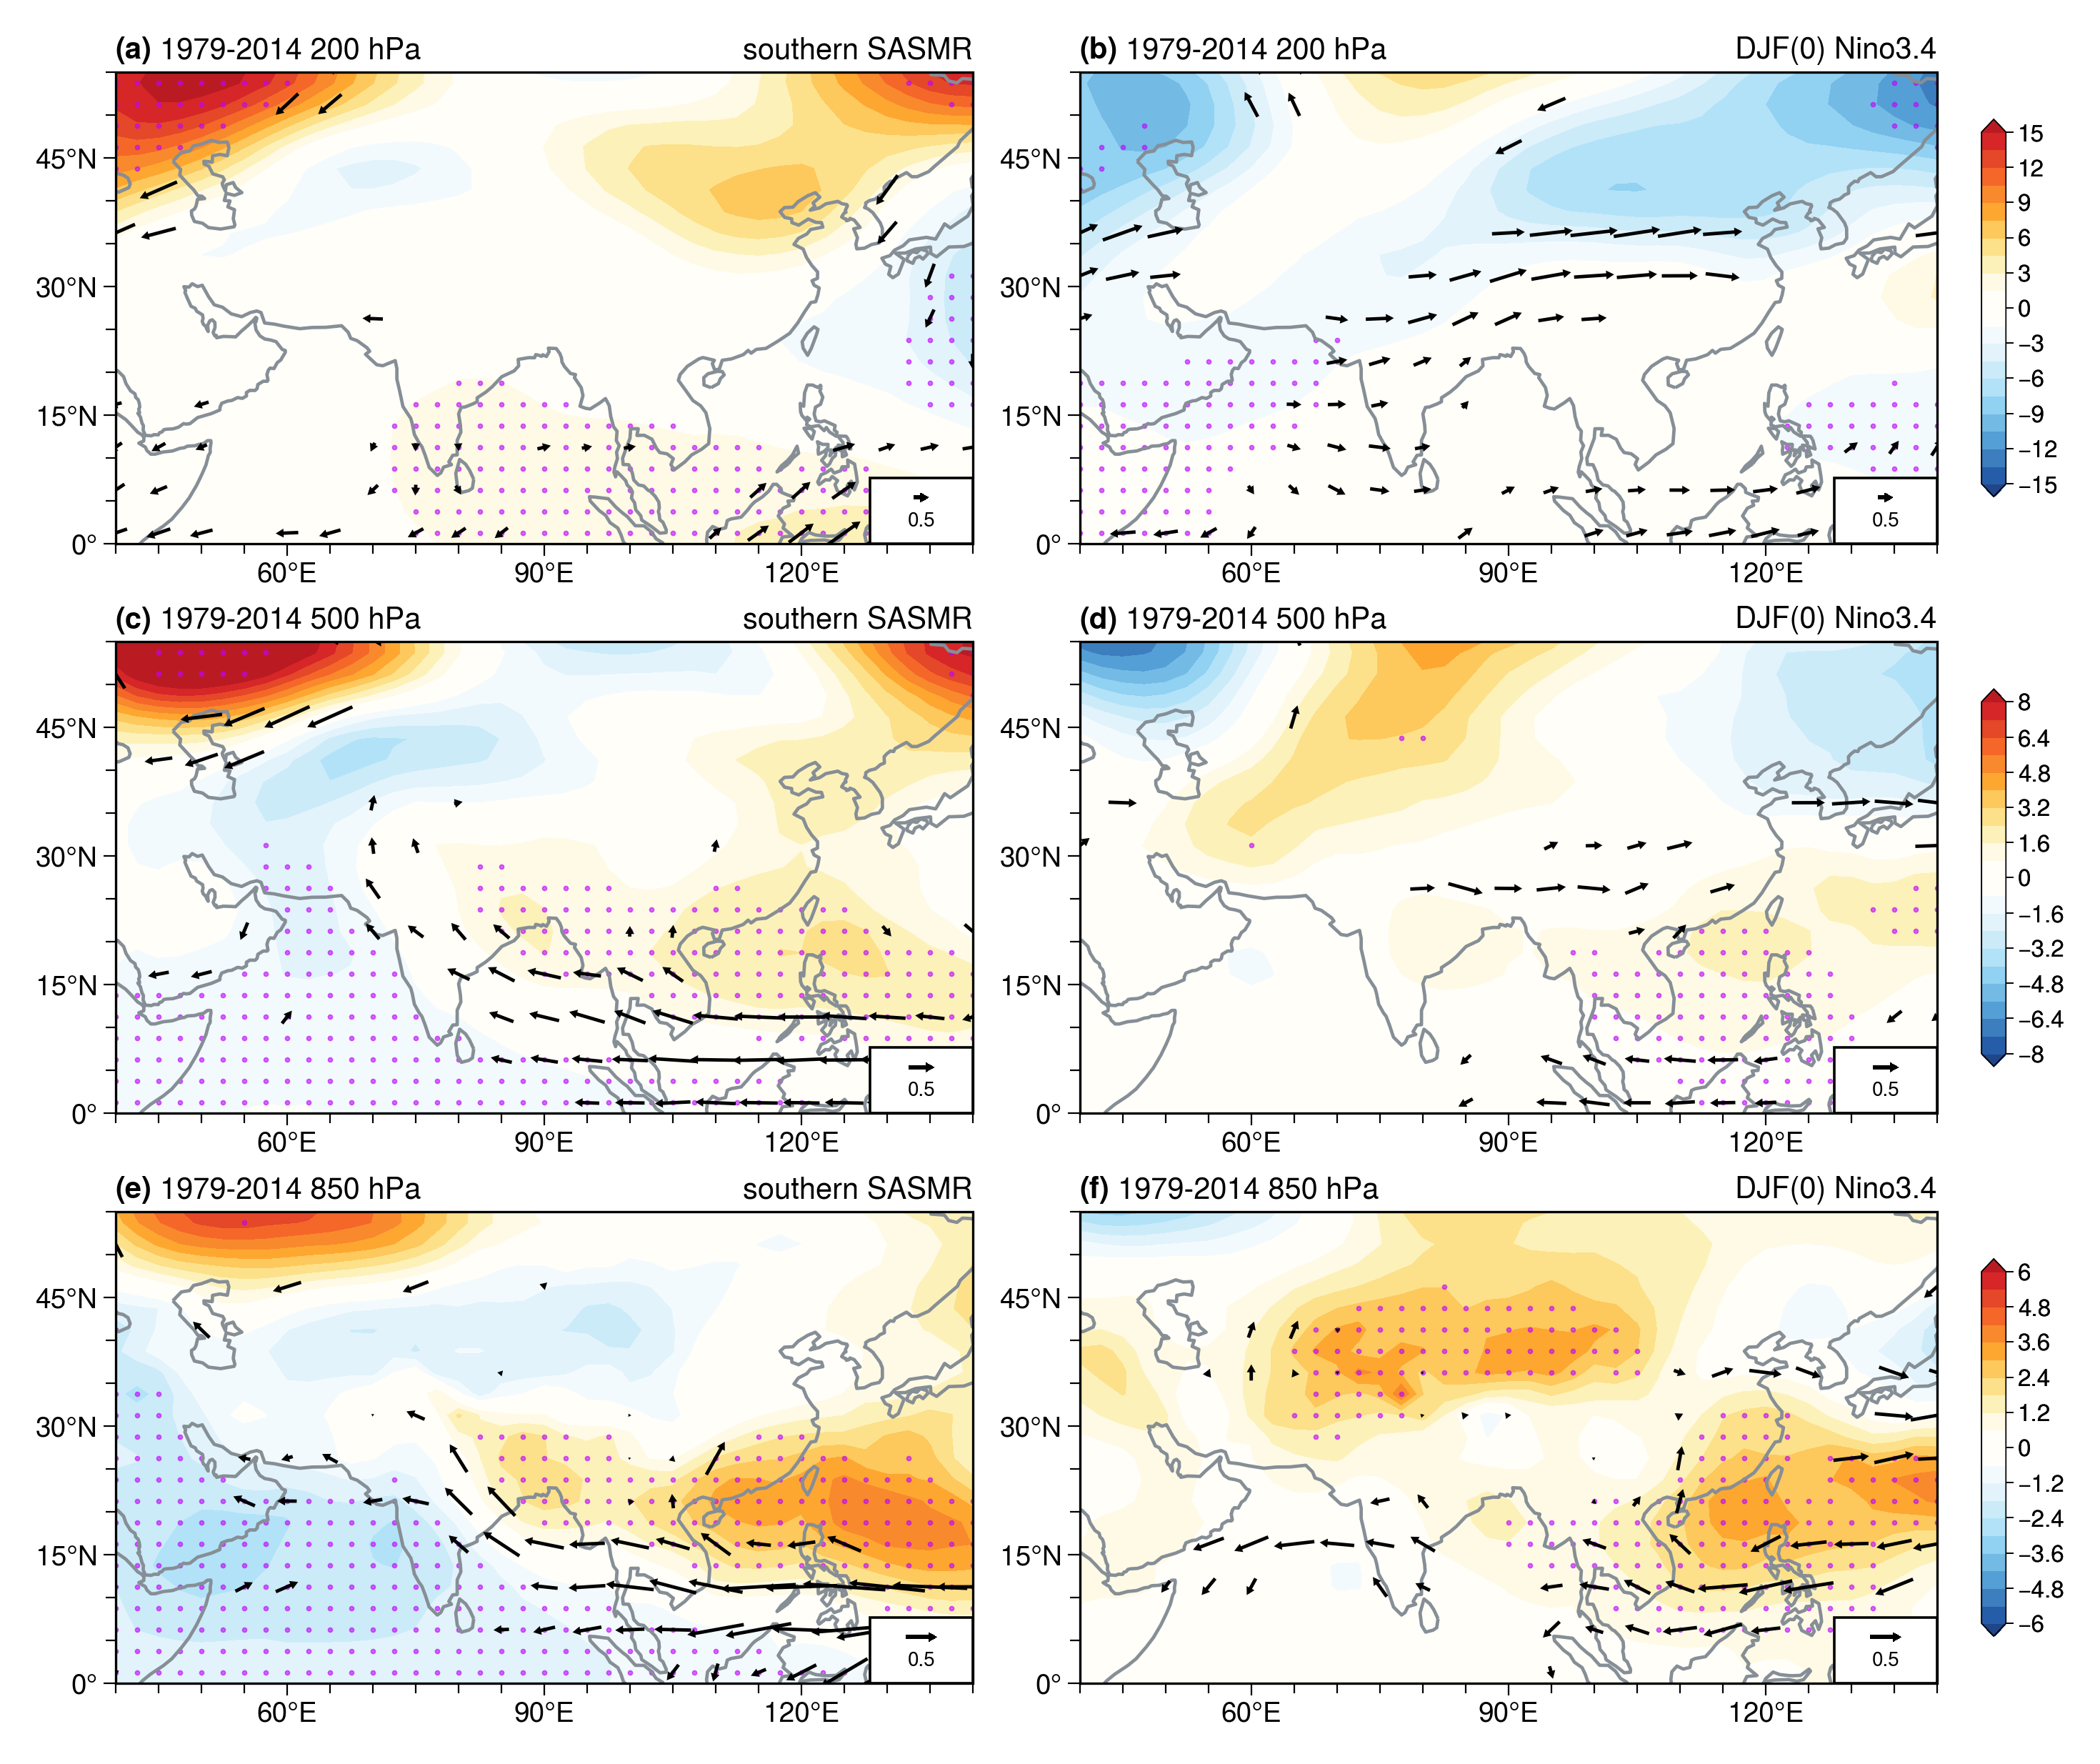

In [11]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig_GPCP_8 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
nrows = 3
ncols = 2
plot_array = np.reshape(range(1, nrows*ncols+1), (nrows, ncols))
# plot_array[-1,-1] = 0
axs = fig_GPCP_8.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    
    # ======================================
    con = axs[num_lev, 0].contourf(
        hgt_north_south_slope.sel(level=lev)[0, :, :],
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        hgt_north_south_slope.sel(level=lev)[0, :, :], axs[num_lev, 0], n, np.where(hgt_north_south_pvalue.sel(level=lev)[0, ::n, ::n] <= 0.05), "bright purple", 19.0,
    )
    # axs[num_lev, 0].quiver(
    #     IndR_his_u_slope_ens.sel(level=lev)[::ski, ::ski],
    #     IndR_his_v_slope_ens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 0].quiver(
        u_north_south_slope.sel(level=lev).where(wind_north_south_mask.sel(level=lev) > 0.0)[0, ::ski, ::ski],
        v_north_south_slope.sel(level=lev).where(wind_north_south_mask.sel(level=lev) > 0.0)[0, ::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 0].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
    )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="southern SASMR",
    )
    # ======================================
    con = axs[num_lev, 1].contourf(
        hgt_north_south_slope.sel(level=lev)[1, :, :],
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        hgt_north_south_slope.sel(level=lev)[1, :, :], axs[num_lev, 1], n, np.where(hgt_north_south_pvalue.sel(level=lev)[1, ::n, ::n] <= 0.05), "bright purple", 19.0,
    )
    # axs[num_lev, 1].quiver(
    #     IndR_his_u_slope_ens.sel(level=lev)[::ski, ::ski],
    #     IndR_his_v_slope_ens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 1].quiver(
        u_north_south_slope.sel(level=lev).where(wind_north_south_mask.sel(level=lev) > 0.0)[1, ::ski, ::ski],
        v_north_south_slope.sel(level=lev).where(wind_north_south_mask.sel(level=lev) > 0.0)[1, ::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 1].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
    )
    axs[num_lev, 1].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="DJF(0) Nino3.4",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=2.5)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
    # ======================================
    # cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=2.5)
    # cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.2, titlepad=7.0)
fig_GPCP_8.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":15})
pplt.rc.reset()

## CRU

### 计算降水场回归、环流场回归

In [14]:
# 降水场
(
    nIndR_CRU_pre_slope,
    nIndR_CRU_pre_intercept,
    nIndR_CRU_pre_rvalue,
    nIndR_CRU_pre_pvalue,
    nIndR_CRU_pre_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, preCRU_JJA)

(
    sIndR_CRU_pre_slope,
    sIndR_CRU_pre_intercept,
    sIndR_CRU_pre_rvalue,
    sIndR_CRU_pre_pvalue,
    sIndR_CRU_pre_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, preCRU_JJA)

(
    IndR_CRU_pre_slope,
    IndR_CRU_pre_intercept,
    IndR_CRU_pre_rvalue,
    IndR_CRU_pre_pvalue,
    IndR_CRU_pre_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, preCRU_JJA)

In [15]:
# 环流场/风场
preCRU_nIndia_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
preCRU_sIndia_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
preCRU_India_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
(
    nIndR_ERA5_hgt_slope,
    nIndR_ERA5_hgt_intercept,
    nIndR_ERA5_hgt_rvalue,
    nIndR_ERA5_hgt_pvalue,
    nIndR_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ERA5_u_slope,
    nIndR_ERA5_u_intercept,
    nIndR_ERA5_u_rvalue,
    nIndR_ERA5_u_pvalue,
    nIndR_ERA5_u_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ERA5_v_slope,
    nIndR_ERA5_v_intercept,
    nIndR_ERA5_v_rvalue,
    nIndR_ERA5_v_pvalue,
    nIndR_ERA5_v_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sIndR_ERA5_hgt_slope,
    sIndR_ERA5_hgt_intercept,
    sIndR_ERA5_hgt_rvalue,
    sIndR_ERA5_hgt_pvalue,
    sIndR_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sIndR_ERA5_u_slope,
    sIndR_ERA5_u_intercept,
    sIndR_ERA5_u_rvalue,
    sIndR_ERA5_u_pvalue,
    sIndR_ERA5_u_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sIndR_ERA5_v_slope,
    sIndR_ERA5_v_intercept,
    sIndR_ERA5_v_rvalue,
    sIndR_ERA5_v_pvalue,
    sIndR_ERA5_v_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    IndR_ERA5_hgt_slope,
    IndR_ERA5_hgt_intercept,
    IndR_ERA5_hgt_rvalue,
    IndR_ERA5_hgt_pvalue,
    IndR_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    IndR_ERA5_u_slope,
    IndR_ERA5_u_intercept,
    IndR_ERA5_u_rvalue,
    IndR_ERA5_u_pvalue,
    IndR_ERA5_u_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    IndR_ERA5_v_slope,
    IndR_ERA5_v_intercept,
    IndR_ERA5_v_rvalue,
    IndR_ERA5_v_pvalue,
    IndR_ERA5_v_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

In [16]:
# 垂直运动场和散度场
tmp = preCRU_nIndia_JJA_nor[1:].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    nIndR_ERA5_wDJF_slope,
    nIndR_ERA5_wDJF_intercept,
    nIndR_ERA5_wDJF_rvalue,
    nIndR_ERA5_wDJF_pvalue,
    nIndR_ERA5_wDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

tmp = preCRU_nIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_MAM.time
(
    nIndR_ERA5_wMAM_slope,
    nIndR_ERA5_wMAM_intercept,
    nIndR_ERA5_wMAM_rvalue,
    nIndR_ERA5_wMAM_pvalue,
    nIndR_ERA5_wMAM_hypothesis,
) = ca.dim_linregress(tmp, wERA5_MAM.sel(level=500.0))

tmp = preCRU_nIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_JJA.time
(
    nIndR_ERA5_wJJA_slope,
    nIndR_ERA5_wJJA_intercept,
    nIndR_ERA5_wJJA_rvalue,
    nIndR_ERA5_wJJA_pvalue,
    nIndR_ERA5_wJJA_hypothesis,
) = ca.dim_linregress(tmp, wERA5_JJA.sel(level=500.0))

tmp = preCRU_nIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_SON.time
(
    nIndR_ERA5_wSON_slope,
    nIndR_ERA5_wSON_intercept,
    nIndR_ERA5_wSON_rvalue,
    nIndR_ERA5_wSON_pvalue,
    nIndR_ERA5_wSON_hypothesis,
) = ca.dim_linregress(tmp, wERA5_SON.sel(level=500.0))

tmp = preCRU_nIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    nIndR_ERA5_wnDJF_slope,
    nIndR_ERA5_wnDJF_intercept,
    nIndR_ERA5_wnDJF_rvalue,
    nIndR_ERA5_wnDJF_pvalue,
    nIndR_ERA5_wnDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

(
    nIndR_ERA5_div_slope,
    nIndR_ERA5_div_intercept,
    nIndR_ERA5_div_rvalue,
    nIndR_ERA5_div_pvalue,
    nIndR_ERA5_div_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

tmp = preCRU_sIndia_JJA_nor[1:].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    sIndR_ERA5_wDJF_slope,
    sIndR_ERA5_wDJF_intercept,
    sIndR_ERA5_wDJF_rvalue,
    sIndR_ERA5_wDJF_pvalue,
    sIndR_ERA5_wDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

tmp = preCRU_sIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_MAM.time
(
    sIndR_ERA5_wMAM_slope,
    sIndR_ERA5_wMAM_intercept,
    sIndR_ERA5_wMAM_rvalue,
    sIndR_ERA5_wMAM_pvalue,
    sIndR_ERA5_wMAM_hypothesis,
) = ca.dim_linregress(tmp, wERA5_MAM.sel(level=500.0))

tmp = preCRU_sIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_JJA.time
(
    sIndR_ERA5_wJJA_slope,
    sIndR_ERA5_wJJA_intercept,
    sIndR_ERA5_wJJA_rvalue,
    sIndR_ERA5_wJJA_pvalue,
    sIndR_ERA5_wJJA_hypothesis,
) = ca.dim_linregress(tmp, wERA5_JJA.sel(level=500.0))

tmp = preCRU_sIndia_JJA_nor.copy()
tmp.coords["time"] = wERA5_SON.time
(
    sIndR_ERA5_wSON_slope,
    sIndR_ERA5_wSON_intercept,
    sIndR_ERA5_wSON_rvalue,
    sIndR_ERA5_wSON_pvalue,
    sIndR_ERA5_wSON_hypothesis,
) = ca.dim_linregress(tmp, wERA5_SON.sel(level=500.0))

tmp = preCRU_sIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    sIndR_ERA5_wnDJF_slope,
    sIndR_ERA5_wnDJF_intercept,
    sIndR_ERA5_wnDJF_rvalue,
    sIndR_ERA5_wnDJF_pvalue,
    sIndR_ERA5_wnDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

(
    sIndR_ERA5_div_slope,
    sIndR_ERA5_div_intercept,
    sIndR_ERA5_div_rvalue,
    sIndR_ERA5_div_pvalue,
    sIndR_ERA5_div_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

tmp = preCRU_India_JJA_nor[1:].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    IndR_ERA5_wDJF_slope,
    IndR_ERA5_wDJF_intercept,
    IndR_ERA5_wDJF_rvalue,
    IndR_ERA5_wDJF_pvalue,
    IndR_ERA5_wDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

tmp = preCRU_India_JJA_nor.copy()
tmp.coords["time"] = wERA5_MAM.time
(
    IndR_ERA5_wMAM_slope,
    IndR_ERA5_wMAM_intercept,
    IndR_ERA5_wMAM_rvalue,
    IndR_ERA5_wMAM_pvalue,
    IndR_ERA5_wMAM_hypothesis,
) = ca.dim_linregress(tmp, wERA5_MAM.sel(level=500.0))

tmp = preCRU_India_JJA_nor.copy()
tmp.coords["time"] = wERA5_JJA.time
(
    IndR_ERA5_wJJA_slope,
    IndR_ERA5_wJJA_intercept,
    IndR_ERA5_wJJA_rvalue,
    IndR_ERA5_wJJA_pvalue,
    IndR_ERA5_wJJA_hypothesis,
) = ca.dim_linregress(tmp, wERA5_JJA.sel(level=500.0))

tmp = preCRU_India_JJA_nor.copy()
tmp.coords["time"] = wERA5_SON.time
(
    IndR_ERA5_wSON_slope,
    IndR_ERA5_wSON_intercept,
    IndR_ERA5_wSON_rvalue,
    IndR_ERA5_wSON_pvalue,
    IndR_ERA5_wSON_hypothesis,
) = ca.dim_linregress(tmp, wERA5_SON.sel(level=500.0))

tmp = preCRU_India_JJA_nor[:-1].copy()
tmp.coords["time"] = wERA5_DJF.time
(
    IndR_ERA5_wnDJF_slope,
    IndR_ERA5_wnDJF_intercept,
    IndR_ERA5_wnDJF_rvalue,
    IndR_ERA5_wnDJF_pvalue,
    IndR_ERA5_wnDJF_hypothesis,
) = ca.dim_linregress(tmp, wERA5_DJF.sel(level=500.0))

(
    IndR_ERA5_div_slope,
    IndR_ERA5_div_intercept,
    IndR_ERA5_div_rvalue,
    IndR_ERA5_div_pvalue,
    IndR_ERA5_div_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

In [17]:
level = nIndR_ERA5_hgt_slope.coords["level"]

nIndR_CRU_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_CRU_pre_slope.data),
        intercept=(["lat", "lon"], nIndR_CRU_pre_intercept.data),
        rvalue=(["lat", "lon"], nIndR_CRU_pre_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_CRU_pre_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_CRU_pre_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="pre fields of CRU regress onto 1979-2014 "),
)

nIndR_ERA5_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_hgt_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_hgt_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_hgt_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_u_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_u_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_u_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_u_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_u_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_v_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_v_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_v_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_v_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_v_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wMAM_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wMAM_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wMAM_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wMAM_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wJJA_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wJJA_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wJJA_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wJJA_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wSON_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wSON_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wSON_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wSON_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_wnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_wnDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_wnDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_wnDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_wnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_wnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_div_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_div_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_div_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_div_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_div_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_div_hypothesis.data),
    ),
    coords=dict(
        level=nIndR_ERA5_div_slope.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
)

sIndR_CRU_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_CRU_pre_slope.data),
        intercept=(["lat", "lon"], sIndR_CRU_pre_intercept.data),
        rvalue=(["lat", "lon"], sIndR_CRU_pre_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_CRU_pre_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_CRU_pre_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="pre fields of CRU regress onto 1979-2014 "),
)

sIndR_ERA5_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_hgt_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_hgt_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_hgt_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_hgt_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_hgt_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_u_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_u_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_u_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_u_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_u_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_v_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_v_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_v_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_v_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_v_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wMAM_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wMAM_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wMAM_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wMAM_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wJJA_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wJJA_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wJJA_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wJJA_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wSON_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wSON_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wSON_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wSON_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_wnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_wnDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_wnDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_wnDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_wnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_wnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_div_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], sIndR_ERA5_div_slope.data),
        intercept=(["level", "lat", "lon"], sIndR_ERA5_div_intercept.data),
        rvalue=(["level", "lat", "lon"], sIndR_ERA5_div_rvalue.data),
        pvalue=(["level", "lat", "lon"], sIndR_ERA5_div_pvalue.data),
        hypothesis=(["level", "lat", "lon"], sIndR_ERA5_div_hypothesis.data),
    ),
    coords=dict(
        level=sIndR_ERA5_div_slope.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
)

IndR_CRU_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_CRU_pre_slope.data),
        intercept=(["lat", "lon"], IndR_CRU_pre_intercept.data),
        rvalue=(["lat", "lon"], IndR_CRU_pre_rvalue.data),
        pvalue=(["lat", "lon"], IndR_CRU_pre_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_CRU_pre_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="pre fields of CRU regress onto 1979-2014 "),
)

IndR_ERA5_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_hgt_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_hgt_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_hgt_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_hgt_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_hgt_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_u_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_u_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_u_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_u_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_u_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_v_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_v_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_v_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_v_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_v_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wMAM_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wMAM_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wMAM_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wMAM_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wJJA_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wJJA_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wJJA_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wJJA_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wSON_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wSON_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wSON_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wSON_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_wnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_wnDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_wnDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_wnDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_wnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_wnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_div_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], IndR_ERA5_div_slope.data),
        intercept=(["level", "lat", "lon"], IndR_ERA5_div_intercept.data),
        rvalue=(["level", "lat", "lon"], IndR_ERA5_div_rvalue.data),
        pvalue=(["level", "lat", "lon"], IndR_ERA5_div_pvalue.data),
        hypothesis=(["level", "lat", "lon"], IndR_ERA5_div_hypothesis.data),
    ),
    coords=dict(
        level=IndR_ERA5_div_slope.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
)

if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_CRU_pre_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_CRU_pre_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_hgt_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_hgt_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_u_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_u_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_v_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_v_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wnDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_div_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_div_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_CRU_pre_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_CRU_pre_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_hgt_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_hgt_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_u_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_u_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_v_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_v_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wnDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_div_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_div_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_CRU_pre_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_CRU_pre_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_hgt_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_hgt_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_u_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_u_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_v_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_v_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wnDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_div_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_div_regress.nc")
# ====================================================================
nIndR_CRU_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_CRU_pre_regress.nc")
nIndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_hgt_regress.nc")
nIndR_ERA5_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_u_regress.nc")
nIndR_ERA5_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_v_regress.nc")
nIndR_ERA5_wDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wDJF_regress.nc")
nIndR_ERA5_wMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wMAM_regress.nc")
nIndR_ERA5_wJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wJJA_regress.nc")
nIndR_ERA5_wSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wSON_regress.nc")
nIndR_ERA5_wnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_wnDJF_regress.nc")
nIndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_div_regress.nc")

sIndR_CRU_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_CRU_pre_regress.nc")
sIndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_hgt_regress.nc")
sIndR_ERA5_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_u_regress.nc")
sIndR_ERA5_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_v_regress.nc")
sIndR_ERA5_wDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wDJF_regress.nc")
sIndR_ERA5_wMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wMAM_regress.nc")
sIndR_ERA5_wJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wJJA_regress.nc")
sIndR_ERA5_wSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wSON_regress.nc")
sIndR_ERA5_wnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_wnDJF_regress.nc")
sIndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_div_regress.nc")

IndR_CRU_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_CRU_pre_regress.nc")
IndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_hgt_regress.nc")
IndR_ERA5_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_u_regress.nc")
IndR_ERA5_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_v_regress.nc")
IndR_ERA5_wDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wDJF_regress.nc")
IndR_ERA5_wMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wMAM_regress.nc")
IndR_ERA5_wJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wJJA_regress.nc")
IndR_ERA5_wSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wSON_regress.nc")
IndR_ERA5_wnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_wnDJF_regress.nc")
IndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_div_regress.nc")

### 计算前期冬季、前期春期、同期夏季、后期秋季、后期冬季的海温回归异常

In [18]:
# 印度半岛北部降水
# 前期冬季
tmp = preCRU_nIndia_JJA_nor[1:].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    nIndR_ERA5_sstDJF_slope,
    nIndR_ERA5_sstDJF_intercept,
    nIndR_ERA5_sstDJF_rvalue,
    nIndR_ERA5_sstDJF_pvalue,
    nIndR_ERA5_sstDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 前期春季
tmp = preCRU_nIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_MAM.time
(
    nIndR_ERA5_sstMAM_slope,
    nIndR_ERA5_sstMAM_intercept,
    nIndR_ERA5_sstMAM_rvalue,
    nIndR_ERA5_sstMAM_pvalue,
    nIndR_ERA5_sstMAM_hypothesis,
) = ca.dim_linregress(tmp, sstHad_MAM)

# 同期夏季
tmp = preCRU_nIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_JJA.time
(
    nIndR_ERA5_sstJJA_slope,
    nIndR_ERA5_sstJJA_intercept,
    nIndR_ERA5_sstJJA_rvalue,
    nIndR_ERA5_sstJJA_pvalue,
    nIndR_ERA5_sstJJA_hypothesis,
) = ca.dim_linregress(tmp, sstHad_JJA)

# 后期秋季
tmp = preCRU_nIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_SON.time
(
    nIndR_ERA5_sstSON_slope,
    nIndR_ERA5_sstSON_intercept,
    nIndR_ERA5_sstSON_rvalue,
    nIndR_ERA5_sstSON_pvalue,
    nIndR_ERA5_sstSON_hypothesis,
) = ca.dim_linregress(tmp, sstHad_SON)

# 后期冬季
tmp = preCRU_nIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    nIndR_ERA5_sstnDJF_slope,
    nIndR_ERA5_sstnDJF_intercept,
    nIndR_ERA5_sstnDJF_rvalue,
    nIndR_ERA5_sstnDJF_pvalue,
    nIndR_ERA5_sstnDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 印度半岛南部降水
# 前期冬季
tmp = preCRU_sIndia_JJA_nor[1:].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    sIndR_ERA5_sstDJF_slope,
    sIndR_ERA5_sstDJF_intercept,
    sIndR_ERA5_sstDJF_rvalue,
    sIndR_ERA5_sstDJF_pvalue,
    sIndR_ERA5_sstDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 前期春季
tmp = preCRU_sIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_MAM.time
(
    sIndR_ERA5_sstMAM_slope,
    sIndR_ERA5_sstMAM_intercept,
    sIndR_ERA5_sstMAM_rvalue,
    sIndR_ERA5_sstMAM_pvalue,
    sIndR_ERA5_sstMAM_hypothesis,
) = ca.dim_linregress(tmp, sstHad_MAM)

# 同期夏季
tmp = preCRU_sIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_JJA.time
(
    sIndR_ERA5_sstJJA_slope,
    sIndR_ERA5_sstJJA_intercept,
    sIndR_ERA5_sstJJA_rvalue,
    sIndR_ERA5_sstJJA_pvalue,
    sIndR_ERA5_sstJJA_hypothesis,
) = ca.dim_linregress(tmp, sstHad_JJA)

# 后期秋季
tmp = preCRU_sIndia_JJA_nor.copy()
tmp.coords["time"] = sstHad_SON.time
(
    sIndR_ERA5_sstSON_slope,
    sIndR_ERA5_sstSON_intercept,
    sIndR_ERA5_sstSON_rvalue,
    sIndR_ERA5_sstSON_pvalue,
    sIndR_ERA5_sstSON_hypothesis,
) = ca.dim_linregress(tmp, sstHad_SON)

# 后期冬季
tmp = preCRU_sIndia_JJA_nor[:-1].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    sIndR_ERA5_sstnDJF_slope,
    sIndR_ERA5_sstnDJF_intercept,
    sIndR_ERA5_sstnDJF_rvalue,
    sIndR_ERA5_sstnDJF_pvalue,
    sIndR_ERA5_sstnDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 全印度半岛降水
# 前期冬季
tmp = preCRU_India_JJA_nor[1:].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    IndR_ERA5_sstDJF_slope,
    IndR_ERA5_sstDJF_intercept,
    IndR_ERA5_sstDJF_rvalue,
    IndR_ERA5_sstDJF_pvalue,
    IndR_ERA5_sstDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)

# 前期春季
tmp = preCRU_India_JJA_nor.copy()
tmp.coords["time"] = sstHad_MAM.time
(
    IndR_ERA5_sstMAM_slope,
    IndR_ERA5_sstMAM_intercept,
    IndR_ERA5_sstMAM_rvalue,
    IndR_ERA5_sstMAM_pvalue,
    IndR_ERA5_sstMAM_hypothesis,
) = ca.dim_linregress(tmp, sstHad_MAM)

# 同期夏季
tmp = preCRU_India_JJA_nor.copy()
tmp.coords["time"] = sstHad_JJA.time
(
    IndR_ERA5_sstJJA_slope,
    IndR_ERA5_sstJJA_intercept,
    IndR_ERA5_sstJJA_rvalue,
    IndR_ERA5_sstJJA_pvalue,
    IndR_ERA5_sstJJA_hypothesis,
) = ca.dim_linregress(tmp, sstHad_JJA)

# 后期秋季
tmp = preCRU_India_JJA_nor.copy()
tmp.coords["time"] = sstHad_SON.time
(
    IndR_ERA5_sstSON_slope,
    IndR_ERA5_sstSON_intercept,
    IndR_ERA5_sstSON_rvalue,
    IndR_ERA5_sstSON_pvalue,
    IndR_ERA5_sstSON_hypothesis,
) = ca.dim_linregress(tmp, sstHad_SON)

# 后期冬季
tmp = preCRU_India_JJA_nor[:-1].copy()
tmp.coords["time"] = sstHad_DJF.time
(
    IndR_ERA5_sstnDJF_slope,
    IndR_ERA5_sstnDJF_intercept,
    IndR_ERA5_sstnDJF_rvalue,
    IndR_ERA5_sstnDJF_pvalue,
    IndR_ERA5_sstnDJF_hypothesis,
) = ca.dim_linregress(tmp, sstHad_DJF)


In [19]:
nIndR_ERA5_sstDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstMAM_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstMAM_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstMAM_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstMAM_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstJJA_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstJJA_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstJJA_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstJJA_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstSON_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstSON_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstSON_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstSON_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

nIndR_ERA5_sstnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_sstnDJF_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_sstnDJF_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_sstnDJF_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_sstnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_sstnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstMAM_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstMAM_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstMAM_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstMAM_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstJJA_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstJJA_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstJJA_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstJJA_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstSON_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstSON_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstSON_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstSON_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

sIndR_ERA5_sstnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_sstnDJF_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_sstnDJF_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_sstnDJF_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_sstnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_sstnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstMAM_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstMAM_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstMAM_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstMAM_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstMAM_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstMAM_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstJJA_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstJJA_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstJJA_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstJJA_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstJJA_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstJJA_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstSON_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstSON_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstSON_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstSON_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstSON_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstSON_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)

IndR_ERA5_sstnDJF_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_sstnDJF_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_sstnDJF_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_sstnDJF_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_sstnDJF_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_sstnDJF_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
)
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstnDJF_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstnDJF_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstDJF_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstMAM_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstMAM_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstJJA_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstJJA_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstSON_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstSON_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstnDJF_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstnDJF_regress.nc")

nIndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstDJF_regress.nc")
nIndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstMAM_regress.nc")
nIndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstJJA_regress.nc")
nIndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstSON_regress.nc")
nIndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_sstnDJF_regress.nc")

sIndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstDJF_regress.nc")
sIndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstMAM_regress.nc")
sIndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstJJA_regress.nc")
sIndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstSON_regress.nc")
sIndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_sstnDJF_regress.nc")

IndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstDJF_regress.nc")
IndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstMAM_regress.nc")
IndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstJJA_regress.nc")
IndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstSON_regress.nc")
IndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_sstnDJF_regress.nc")

### 计算垂直积分水汽通量、水汽通量散度回归

In [20]:
# 印度半岛北部降水
(
    nIndR_ERA5_uq_slope,
    nIndR_ERA5_uq_intercept,
    nIndR_ERA5_uq_rvalue,
    nIndR_ERA5_uq_pvalue,
    nIndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, uqERA5_ver_JJA)

(
    nIndR_ERA5_vq_slope,
    nIndR_ERA5_vq_intercept,
    nIndR_ERA5_vq_rvalue,
    nIndR_ERA5_vq_pvalue,
    nIndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, vqERA5_ver_JJA)

(
    nIndR_ERA5_uqvqdiv_slope,
    nIndR_ERA5_uqvqdiv_intercept,
    nIndR_ERA5_uqvqdiv_rvalue,
    nIndR_ERA5_uqvqdiv_pvalue,
    nIndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preCRU_nIndia_JJA_nor, uqvqdivERA5_ver_JJA)

# 印度半岛南部降水
(
    sIndR_ERA5_uq_slope,
    sIndR_ERA5_uq_intercept,
    sIndR_ERA5_uq_rvalue,
    sIndR_ERA5_uq_pvalue,
    sIndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, uqERA5_ver_JJA)

(
    sIndR_ERA5_vq_slope,
    sIndR_ERA5_vq_intercept,
    sIndR_ERA5_vq_rvalue,
    sIndR_ERA5_vq_pvalue,
    sIndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, vqERA5_ver_JJA)

(
    sIndR_ERA5_uqvqdiv_slope,
    sIndR_ERA5_uqvqdiv_intercept,
    sIndR_ERA5_uqvqdiv_rvalue,
    sIndR_ERA5_uqvqdiv_pvalue,
    sIndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preCRU_sIndia_JJA_nor, uqvqdivERA5_ver_JJA)

# 印度半岛降水
(
    IndR_ERA5_uq_slope,
    IndR_ERA5_uq_intercept,
    IndR_ERA5_uq_rvalue,
    IndR_ERA5_uq_pvalue,
    IndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, uqERA5_ver_JJA)

(
    IndR_ERA5_vq_slope,
    IndR_ERA5_vq_intercept,
    IndR_ERA5_vq_rvalue,
    IndR_ERA5_vq_pvalue,
    IndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, vqERA5_ver_JJA)

(
    IndR_ERA5_uqvqdiv_slope,
    IndR_ERA5_uqvqdiv_intercept,
    IndR_ERA5_uqvqdiv_rvalue,
    IndR_ERA5_uqvqdiv_pvalue,
    IndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preCRU_India_JJA_nor, uqvqdivERA5_ver_JJA)

In [21]:
nIndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

IndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], IndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], IndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], IndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], IndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], IndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_uqvqdiv_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_uqvqdiv_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_uqvqdiv_regress.nc")

nIndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_uq_regress.nc")
nIndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_vq_regress.nc")
nIndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/CRU/detrend/nIndR_ERA5_uqvqdiv_regress.nc")

sIndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_uq_regress.nc")
sIndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_vq_regress.nc")
sIndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/CRU/detrend/sIndR_ERA5_uqvqdiv_regress.nc")

IndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_uq_regress.nc")
IndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_vq_regress.nc")
IndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/IndR_ERA5_uqvqdiv_regress.nc")

### 计算降水的偏回归系数

In [22]:
preCRU_JJA.coords["time"] = preCRU_nIndia_JJA_nor.time
pre_north_south_avalue, pre_north_south_pvalue = ca.multi_var_regression(preCRU_JJA, [preCRU_nIndia_JJA_nor, preCRU_sIndia_JJA_nor], concat_dim="area")
hgt_north_south_avalue, hgt_north_south_pvalue = ca.multi_var_regression(hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]), [preCRU_nIndia_JJA_nor, preCRU_sIndia_JJA_nor], concat_dim="area")
u_north_south_avalue, u_north_south_pvalue = ca.multi_var_regression(uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]), [preCRU_nIndia_JJA_nor, preCRU_sIndia_JJA_nor], concat_dim="area")
v_north_south_avalue, v_north_south_pvalue = ca.multi_var_regression(vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]), [preCRU_nIndia_JJA_nor, preCRU_sIndia_JJA_nor], concat_dim="area")

In [23]:
pre_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "lat", "lon"], pre_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "lat", "lon"], pre_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="precipitation partially regression onto north or south precipitation"),
)

hgt_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "level", "lat", "lon"], hgt_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "level", "lat", "lon"], hgt_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        level=hgt_north_south_avalue.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt partially regression onto north or south precipitation"),
)

u_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "level", "lat", "lon"], u_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "level", "lat", "lon"], u_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        level=u_north_south_avalue.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u partially regression onto north or south precipitation"),
)

v_north_south_partial_correlation = xr.Dataset(
    data_vars=dict(
        slope=(["area", "level", "lat", "lon"], v_north_south_avalue.transpose("area", ...).data),
        pvalue=(["area", "level", "lat", "lon"], v_north_south_pvalue.transpose("area", ...).data),
    ),
    coords=dict(
        area=np.array(["north", "south"]),
        level=v_north_south_avalue.level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v partially regression onto north or south precipitation"),
)
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/pre_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/pre_north_south_partial_correlation.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/hgt_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/hgt_north_south_partial_correlation.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/u_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/u_north_south_partial_correlation.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/v_north_south_partial_correlation.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/v_north_south_partial_correlation.nc")

pre_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/pre_north_south_partial_correlation.nc")
hgt_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/hgt_north_south_partial_correlation.nc")
u_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/u_north_south_partial_correlation.nc")
v_north_south_partial_correlation.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/CRU/detrend/v_north_south_partial_correlation.nc")